In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset
import torchaudio
from torch.utils.data import DataLoader
import os
import numpy as np
import torch.nn.functional as F
from konlpy.tag import Okt

In [16]:
df = pd.read_csv("text/part1.csv")

In [17]:
df

,id,form,original_form,speaker_id,start,end,age,sex
0,SDRW2000000319.1.1.1,병역 특례를 받아,병역 특례를 받아,SD2001645,4.04903,5.83905,10대,여성
1,SDRW2000000319.1.1.2,법정 봉사활동 기 시간을 채워야 하는,법정 봉사활동 기 시간을 채워야 하는,SD2001645,5.84901,8.89405,10대,여성
2,SDRW2000000319.1.1.3,예술,예술,SD2001645,8.90407,9.52506,10대,여성
3,SDRW2000000319.1.1.4,또는 체육 요원의 절반가량이,또는 체육 요원의 절반가량이,SD2001645,9.53506,12.05203,10대,여성
4,SDRW2000000319.1.1.5,허위 자료를 내거나,허위 자료를 내거나,SD2001645,12.06204,13.79504,10대,여성
...,...,...,...,...,...,...,...,...
213188,SDRW2000000418.1.1.326,우선,우선,SD2000552,908.12707,909.98106,10대,여성
213189,SDRW2000000418.1.1.327,맛있는 음식들 먹으면서,맛있는 음식들 먹으면서,SD2000552,909.99104,912.25405,10대,여성
213190,SDRW2000000418.1.1.328,겝,겝,SD2000552,912.26403,913.64807,10대,여성
213191,SDRW2000000418.1.1.329,먹으면서 저도 같이 맛있어 보이는 느낌이라서,먹으면서 저도 같이 맛있어 보이는 느낌이라서,SD2000552,913.65802,917.87305,10대,여성


In [131]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)  # Additional LSTM layer
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm4 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
#         self.init = nn.init.xavier_normal_(tensor, gain=1.0)
#         self.softmax = nn.Softmax()
        
    def forward(self, x):
        h0 = nn.init.xavier_uniform_(torch.randn(1, x.size(0), self.hidden_size).to(x.device), gain=1.0)
        c0 = torch.randn(1, x.size(0), self.hidden_size).to(x.device)
        
        output, (hidden1, cell1) = self.lstm1(x, (h0, c0))
        output, (hidden2, cell2) = self.lstm2(self.relu(output), (hidden1, cell1))# Pass output through the second LSTM layer
        output, (hidden3, cell3) = self.lstm3(self.relu(output), (hidden2, cell2))# Pass output through the second LSTM layer
        output, (hidden4, cell4) = self.lstm4(self.relu(output), (hidden3, cell3))# Pass output through the second LSTM layer
        output = self.fc(self.relu(output[:, -1, :]))
        return output

In [19]:
df.isnull().sum()

id                0
form             39
original_form     0
speaker_id        0
start             0
end               0
age               0
sex               0
dtype: int64

In [20]:
df = df.dropna()

In [21]:
df['sex'].value_counts()

sex
여성    149045
남성     64109
Name: count, dtype: int64

In [22]:
df = df[df['sex'] == '여성']

In [23]:
df = df.reset_index()

In [24]:
df['sex'].value_counts()

sex
여성    149045
Name: count, dtype: int64

In [26]:
okt = Okt()
df['token']=df['form'].apply(okt.morphs)

In [27]:
df

,index,id,form,original_form,speaker_id,start,end,age,sex,token
0,0,SDRW2000000319.1.1.1,병역 특례를 받아,병역 특례를 받아,SD2001645,4.04903,5.83905,10대,여성,"[병역, 특례, 를, 받아]"
1,1,SDRW2000000319.1.1.2,법정 봉사활동 기 시간을 채워야 하는,법정 봉사활동 기 시간을 채워야 하는,SD2001645,5.84901,8.89405,10대,여성,"[법정, 봉사활동, 기, 시간, 을, 채워야, 하는]"
2,2,SDRW2000000319.1.1.3,예술,예술,SD2001645,8.90407,9.52506,10대,여성,[예술]
3,3,SDRW2000000319.1.1.4,또는 체육 요원의 절반가량이,또는 체육 요원의 절반가량이,SD2001645,9.53506,12.05203,10대,여성,"[또는, 체육, 요원, 의, 절반, 가량, 이]"
4,4,SDRW2000000319.1.1.5,허위 자료를 내거나,허위 자료를 내거나,SD2001645,12.06204,13.79504,10대,여성,"[허위, 자료, 를, 내, 거나]"
...,...,...,...,...,...,...,...,...,...,...
149040,213188,SDRW2000000418.1.1.326,우선,우선,SD2000552,908.12707,909.98106,10대,여성,[우선]
149041,213189,SDRW2000000418.1.1.327,맛있는 음식들 먹으면서,맛있는 음식들 먹으면서,SD2000552,909.99104,912.25405,10대,여성,"[맛있는, 음식, 들, 먹으면서]"
149042,213190,SDRW2000000418.1.1.328,겝,겝,SD2000552,912.26403,913.64807,10대,여성,[겝]
149043,213191,SDRW2000000418.1.1.329,먹으면서 저도 같이 맛있어 보이는 느낌이라서,먹으면서 저도 같이 맛있어 보이는 느낌이라서,SD2000552,913.65802,917.87305,10대,여성,"[먹으면서, 저, 도, 같이, 맛있어, 보이는, 느낌, 이라서]"


In [62]:
bin_list = []
for i in range(len(df)):
    bin_list.append(df["token"][i])
bin_list = sum(bin_list,[])

In [63]:
bin_list2 = []
for i in range(len(bin_list)):
    temp = bin_list[i]
    if temp not in bin_list2:
        bin_list2.append(temp)

In [64]:
lookup = {tkn: i+2 for i, tkn in enumerate(bin_list2)}
lookup["unk"] = 0
lookup["pad"] = 1

In [65]:
len(lookup)

34188

In [66]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, wav_dir, bin_list):
        self.data = dataframe
        self.wav_dir = wav_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        file_id = self.data.iloc[index]['id']
        wav_path = os.path.join(self.wav_dir, f'{file_id}.wav')
        audio, _ = torchaudio.load(wav_path)
        text = self.data.iloc[index]['token']
        
        token_indices = [lookup[t] for t in text]
        desired_length = 100
        
        token_indices += [1] * (desired_length - len(token_indices))
        token_indices = torch.tensor(token_indices).type(torch.float32)

        return audio, token_indices

In [143]:
num_epochs = 128
batch_size = 100
learning_rate = 2e-03
num_classes = len(df)  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [114]:
wav_dir = './wav_all_stereo(fixed_length)'
dataset = CustomDataset(df[:1000], wav_dir, bin_list2)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [115]:
audio, text = dataset[0]
print("Audio:", audio)
print("Text:", text)

Audio: tensor([[-9.1553e-05,  3.0518e-05,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-9.1553e-05,  3.0518e-05,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])
Text: tensor([2., 3., 4., 5., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


In [116]:
input_size = 221616
hidden_size = 100
output_size = 100

In [117]:
import math
import torch
from torch import Tensor
from torch.optim.optimizer import Optimizer
from typing import List, Optional


class SophiaG(Optimizer):
    def __init__(self, params, lr=1e-4, betas=(0.965, 0.99), rho = 0.04,
         weight_decay=1e-1, *, maximize: bool = False,
         capturable: bool = False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= rho:
            raise ValueError("Invalid rho parameter at index 1: {}".format(rho))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr, betas=betas, rho=rho, 
                        weight_decay=weight_decay, 
                        maximize=maximize, capturable=capturable)
        super(SophiaG, self).__init__(params, defaults)

    def __setstate__(self, state):
        super().__setstate__(state)
        for group in self.param_groups:
            group.setdefault('maximize', False)
            group.setdefault('capturable', False)
        state_values = list(self.state.values())
        step_is_tensor = (len(state_values) != 0) and torch.is_tensor(state_values[0]['step'])
        if not step_is_tensor:
            for s in state_values:
                s['step'] = torch.tensor(float(s['step']))
    
    @torch.no_grad()
    def update_hessian(self):
        for group in self.param_groups:
            beta1, beta2 = group['betas']
            for p in group['params']:
                if p.grad is None:
                    continue
                state = self.state[p]

                if len(state) == 0:
                    state['step'] = torch.zeros((1,), dtype=torch.float, device=p.device) \
                        if self.defaults['capturable'] else torch.tensor(0.)
                    state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    state['hessian'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                
                if 'hessian' not in state.keys():
                    state['hessian'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                state['hessian'].mul_(beta2).addcmul_(p.grad, p.grad, value=1 - beta2)


    @torch.no_grad()
    def step(self, closure=None, bs=5120):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            grads = []
            exp_avgs = []
            state_steps = []
            hessian = []
            beta1, beta2 = group['betas']

            for p in group['params']:
                if p.grad is None:
                    continue
                params_with_grad.append(p)
                
                if p.grad.is_sparse:
                    raise RuntimeError('Hero does not support sparse gradients')
                grads.append(p.grad)
                state = self.state[p]
                # State initialization
                if len(state) == 0:
                    state['step'] = torch.zeros((1,), dtype=torch.float, device=p.device) \
                        if self.defaults['capturable'] else torch.tensor(0.)
                    state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    state['hessian'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                
                if 'hessian' not in state.keys():
                    state['hessian'] = torch.zeros_like(p, memory_format=torch.preserve_format)                

                exp_avgs.append(state['exp_avg'])
                state_steps.append(state['step'])
                hessian.append(state['hessian'])
                
                if self.defaults['capturable']:
                    bs = torch.ones((1,), dtype=torch.float, device=p.device) * bs

            sophiag(params_with_grad,
                  grads,
                  exp_avgs,
                  hessian,
                  state_steps,
                  bs=bs,
                  beta1=beta1,
                  beta2=beta2,
                  rho=group['rho'],
                  lr=group['lr'],
                  weight_decay=group['weight_decay'],
                  maximize=group['maximize'],
                  capturable=group['capturable'])

        return loss

def sophiag(params: List[Tensor],
          grads: List[Tensor],
          exp_avgs: List[Tensor],
          hessian: List[Tensor],
          state_steps: List[Tensor],
          capturable: bool = False,
          *,
          bs: int,
          beta1: float,
          beta2: float,
          rho: float,
          lr: float,
          weight_decay: float,
          maximize: bool):

    if not all(isinstance(t, torch.Tensor) for t in state_steps):
        raise RuntimeError("API has changed, `state_steps` argument must contain a list of singleton tensors")

    
    func = _single_tensor_sophiag

    func(params,
         grads,
         exp_avgs,
         hessian,
         state_steps,
         bs=bs,
         beta1=beta1,
         beta2=beta2,
         rho=rho,
         lr=lr,
         weight_decay=weight_decay,
         maximize=maximize,
         capturable=capturable)

def _single_tensor_sophiag(params: List[Tensor],
                         grads: List[Tensor],
                         exp_avgs: List[Tensor],
                         hessian: List[Tensor],
                         state_steps: List[Tensor],
                         *,
                         bs: int,
                         beta1: float,
                         beta2: float,
                         rho: float,
                         lr: float,
                         weight_decay: float,
                         maximize: bool,
                         capturable: bool):

    for i, param in enumerate(params):
        grad = grads[i] if not maximize else -grads[i]
        exp_avg = exp_avgs[i]
        hess = hessian[i]
        step_t = state_steps[i]

        if capturable:
            assert param.is_cuda and step_t.is_cuda and bs.is_cuda 
            
        if torch.is_complex(param):
            grad = torch.view_as_real(grad)
            exp_avg = torch.view_as_real(exp_avg)
            hess = torch.view_as_real(hess)
            param = torch.view_as_real(param)

        # update step
        step_t += 1

        # Perform stepweight decay
        param.mul_(1 - lr * weight_decay)

        # Decay the first and second moment running average coefficient
        exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
        
        if capturable:
            step = step_t
            step_size = lr 
            step_size_neg = step_size.neg()

            ratio = (exp_avg.abs() / (rho * bs * hess + 1e-15)).clamp(None,1)
            param.addcmul_(exp_avg.sign(), ratio, value=step_size_neg)
        else:
            step = step_t.item()
            step_size_neg = - lr 
            
            ratio = (exp_avg.abs() / (rho * bs * hess + 1e-15)).clamp(None,1)
            param.addcmul_(exp_avg.sign(), ratio, value=step_size_neg)

In [132]:
model = LSTMModel(input_size, hidden_size, output_size).to(device)
# criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=False)
criterion = nn.MSELoss(reduction="mean")
optimizer = SophiaG(model.parameters(), lr=.1, betas=(0.965, 0.99), rho = 0.01, weight_decay=1e-1)
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,
                                        last_epoch=-1,
                                        verbose=False)
total_step = len(dataloader)

In [135]:
timelist = []

In [144]:
from time import time

model.train()
for epoch in range(num_epochs):
    total_loss = 0.0
    total_correct = 0
    start = time()
    if (epoch + 1) % 2 == 0:
        torch.save(model, "./model/Speech2Text-sophia.pt")

    for i, (audio, text) in enumerate(dataloader):
        audio = audio.to(device)
        text = text.to(device)

        outputs = model(audio)
#         print(outputs.dtype)
#         print(text.dtype)
#         input_lengths = torch.full(size=(batch_size,), fill_value=100, dtype=torch.long)
#         output_lengths = torch.full(size=(batch_size,), fill_value=100, dtype=torch.long)
#         loss = criterion(outputs, 
#                          text, 
#                          input_lengths, 
#                          output_lengths)
        loss = criterion(outputs, text)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        text = text.view(-1, 1)
        total_correct += (predicted == text).sum().item()

#         if (i + 1) % 10 == 0:
#             print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')
    scheduler.step()
    epoch_loss = total_loss / (batch_size * total_step)
    epoch_acc = total_correct / (batch_size * total_step)
    end = time()
    
    timelist.append(end-start)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, Time Duration : {end - start:.4f}:')


Epoch [1/128], Loss: 97.5338, Accuracy: 0.0000, Time Duration : 13.5004:
Epoch [2/128], Loss: 97.3788, Accuracy: 0.0000, Time Duration : 15.2726:
Epoch [3/128], Loss: 97.4023, Accuracy: 0.0000, Time Duration : 13.2808:
Epoch [4/128], Loss: 97.5849, Accuracy: 0.0000, Time Duration : 15.4237:
Epoch [5/128], Loss: 97.5203, Accuracy: 0.0000, Time Duration : 12.2717:
Epoch [6/128], Loss: 97.3781, Accuracy: 0.0000, Time Duration : 15.2848:
Epoch [7/128], Loss: 97.4486, Accuracy: 0.0000, Time Duration : 16.2176:
Epoch [8/128], Loss: 97.2993, Accuracy: 0.0000, Time Duration : 17.4829:
Epoch [9/128], Loss: 97.3617, Accuracy: 0.0000, Time Duration : 17.0112:
Epoch [10/128], Loss: 97.3737, Accuracy: 0.0000, Time Duration : 19.1636:
Epoch [11/128], Loss: 97.4052, Accuracy: 0.0000, Time Duration : 18.3306:
Epoch [12/128], Loss: 97.4759, Accuracy: 0.0000, Time Duration : 19.0340:
Epoch [13/128], Loss: 97.4959, Accuracy: 0.0000, Time Duration : 18.4018:
Epoch [14/128], Loss: 97.3585, Accuracy: 0.0000

Epoch [112/128], Loss: 97.2166, Accuracy: 0.0000, Time Duration : 16.9040:
Epoch [113/128], Loss: 97.2140, Accuracy: 0.0000, Time Duration : 12.1306:
Epoch [114/128], Loss: 97.1456, Accuracy: 0.0000, Time Duration : 16.8699:
Epoch [115/128], Loss: 97.1487, Accuracy: 0.0000, Time Duration : 12.2961:
Epoch [116/128], Loss: 97.2421, Accuracy: 0.0000, Time Duration : 16.6499:
Epoch [117/128], Loss: 97.3097, Accuracy: 0.0000, Time Duration : 12.3241:
Epoch [118/128], Loss: 97.1079, Accuracy: 0.0000, Time Duration : 16.7945:
Epoch [119/128], Loss: 97.2259, Accuracy: 0.0000, Time Duration : 12.4370:
Epoch [120/128], Loss: 97.2696, Accuracy: 0.0000, Time Duration : 16.2481:
Epoch [121/128], Loss: 97.2104, Accuracy: 0.0000, Time Duration : 12.3554:
Epoch [122/128], Loss: 97.1385, Accuracy: 0.0000, Time Duration : 16.8979:
Epoch [123/128], Loss: 97.2370, Accuracy: 0.0000, Time Duration : 11.9895:
Epoch [124/128], Loss: 97.2074, Accuracy: 0.0000, Time Duration : 16.6941:
Epoch [125/128], Loss: 97

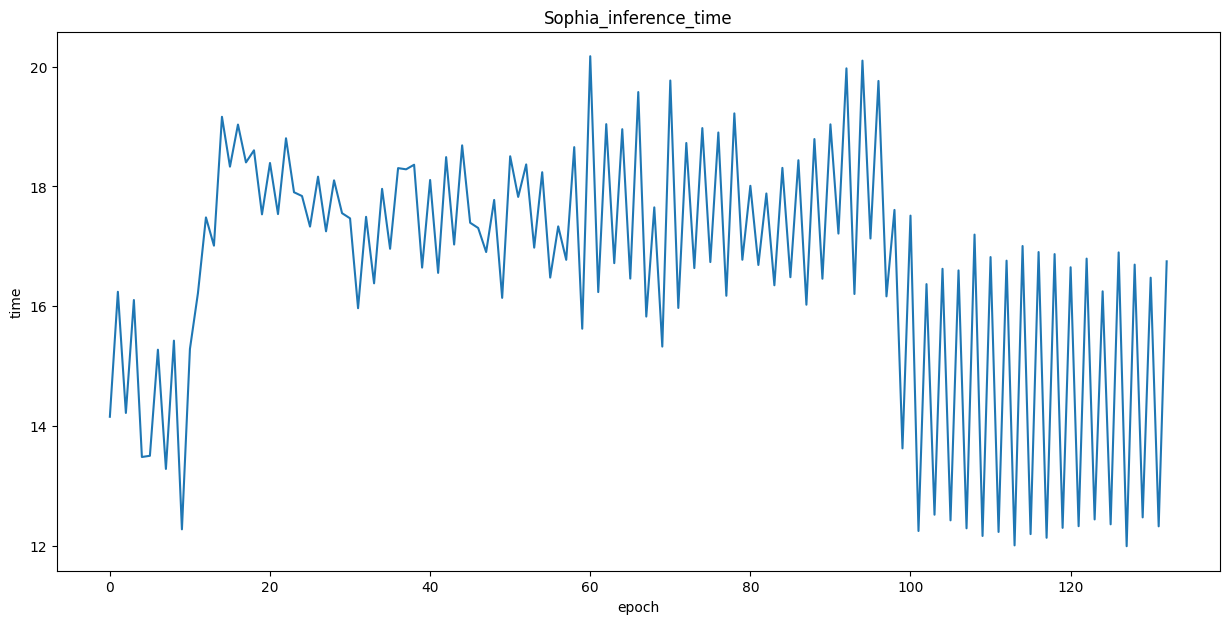

In [145]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,7))
plt.plot(timelist)
plt.title("Sophia_inference_time")
plt.xlabel("epoch")
plt.ylabel("time")
plt.show()

In [ ]:
def predict(model, input_file):
    model.eval()  # 모델을 평가 모드로 설정
    
    audio, _ = torchaudio.load(input_file)  
    audio = audio.unsqueeze(0).to(device) 

    output = model(audio) 

    return output.int().detach()

In [ ]:
output = predict(model,'./wav_all_stereo(fixed_length)/SDRW2000000414.1.1.18.wav')

In [ ]:
output[0,1]

In [ ]:
reverse = dict(map(reversed,lookup.items()))

In [ ]:
out = []
for i in range(len(output[0])):
    out.append(reverse[output[0,i].item()])
out